# **Selected EDA: I chose this dataset to analyze torque based on the other variables.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/BBDD/4datas/electric_vehicles_spec_2025.csv"
import pandas as pd
df = pd.read_csv(path)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [ ]:
df.head() #first 5 rows

,brand,model,top_speed_kmh,battery_capacity_kwh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,towing_capacity_kg,cargo_volume_l,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,0.0,185,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,0.0,360,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,NaN,496,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5


In [ ]:
df.info() #Information about the data, such as the columns and their values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kwh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   efficiency_wh_per_km       478 non-null    int64  
 8   range_km                   478 non-null    int64  
 9   acceleration_0_100_s       478 non-null    float64
 10  fast_charging_power_kw_dc  477 non-null    float64
 11  fast_charge_port           477 non-null    object 
 12  towing_capacity_kg         452 non-null    float64
 13  cargo_volume_l             477 non-null    object 

In [ ]:
def missing_value_summary(df):
    summary = []

    for col in df.columns:
        missing = df[col].isnull().sum()
        total = len(df)
        percent = round((missing / total) * 100, 2)
        dtype = df[col].dtype
        num_unique = df[col].nunique(dropna=True)

        if missing > 0:
            summary.append({
                'Column': col,
                'Data type': dtype,
                'Missing values': missing,
                'Missing (%)': percent,
                'Unique values': num_unique
            })

    return pd.DataFrame(summary).sort_values(by='Missing values', ascending=False)


In [ ]:
def suggest_imputation_strategy(df):
    suggestions = []

    for col in df.columns:
        missing = df[col].isnull().sum()
        total = len(df)
        percent = (missing / total) * 100
        dtype = df[col].dtype
        unique_vals = df[col].nunique()

        if missing > 0:
            if dtype in ['float64', 'int64']:
                strategy = 'Median' if percent < 30 else 'Consider regression or drop'
            elif dtype == 'bool':
                strategy = 'Mode or create missing flag'
            elif dtype == 'object':
                strategy = 'Mode' if unique_vals < 10 else 'Consider "Unknown" or clustering'
            else:
                strategy = 'Manual review'

            suggestions.append({
                'Column': col,
                'Data Type': dtype,
                'Missing (%)': round(percent, 2),
                'Suggested Strategy': strategy
            })

    return pd.DataFrame(suggestions)

In [ ]:
strategy_df = suggest_imputation_strategy(df)
display(strategy_df)

,Column,Data Type,Missing (%),Suggested Strategy
0,model,object,0.21,"Consider ""Unknown"" or clustering"
1,number_of_cells,float64,42.26,Consider regression or drop
2,torque_nm,float64,1.46,Median
3,fast_charging_power_kw_dc,float64,0.21,Median
4,fast_charge_port,object,0.21,Mode
5,towing_capacity_kg,float64,5.44,Median
6,cargo_volume_l,object,0.21,"Consider ""Unknown"" or clustering"


 I say “consider regression” as an imputation strategy, I mean using a regression model to predict missing values based on other related columns. This is especially useful for numerical columns with a high percentage of missing values (like your number_of_cells with 42.26%).

In [ ]:
df_reg_imputed = df.copy(deep=True)

In [ ]:
# Show correlation of all numeric features with 'number_of_cells'
correlations = df_reg_imputed.corr(numeric_only=True)
correlations['number_of_cells'].sort_values(ascending=False)

,number_of_cells
number_of_cells,1.000000
top_speed_kmh,0.361792
range_km,0.311014
battery_capacity_kwh,0.214515
width_mm,0.205763
length_mm,0.181904
torque_nm,0.164120
fast_charging_power_kw_dc,0.094389
towing_capacity_kg,0.070286
seats,0.030315


In [ ]:
# --- 0. Create a copy ---
df_cleaned = df.copy()

# --- 1. Impute numeric columns with median ---
median_cols = ['torque_nm', 'fast_charging_power_kw_dc', 'towing_capacity_kg']
for col in median_cols:
    median = df_cleaned[col].median()
    df_cleaned[col] = df_cleaned[col].fillna(median)

# --- 2. Impute categorical columns with mode ---
mode_cols = ['fast_charge_port']
for col in mode_cols:
    mode = df_cleaned[col].mode()[0]
    df_cleaned[col] = df_cleaned[col].fillna(mode)

# --- 3. Impute low-missing object columns with 'Unknown' ---
unknown_cols = ['model', 'cargo_volume_l']
for col in unknown_cols:
    df_cleaned[col] = df_cleaned[col].fillna('Unknown')

# --- 4. Impute 'number_of_cells' using regression ---
# Select features based on correlation
features = ['battery_capacity_kwh', 'range_km', 'torque_nm']

# Split data into known and unknown
known = df_cleaned[df_cleaned['number_of_cells'].notnull()].dropna(subset=features)
unknown = df_cleaned[df_cleaned['number_of_cells'].isnull()].dropna(subset=features)

# Fit regression model
X_train = known[features]
y_train = known['number_of_cells']
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and fill missing values
X_missing = unknown[features]
predicted = model.predict(X_missing)
df_cleaned.loc[X_missing.index, 'number_of_cells'] = predicted


In [ ]:
# Confirm no missing values remain
print(df_cleaned.isnull().sum())

brand                        0
model                        0
top_speed_kmh                0
battery_capacity_kwh         0
battery_type                 0
number_of_cells              0
torque_nm                    0
efficiency_wh_per_km         0
range_km                     0
acceleration_0_100_s         0
fast_charging_power_kw_dc    0
fast_charge_port             0
towing_capacity_kg           0
cargo_volume_l               0
seats                        0
drivetrain                   0
segment                      0
length_mm                    0
width_mm                     0
height_mm                    0
car_body_type                0
source_url                   0
dtype: int64


# **🔍 1. Univariate Analysis (one variable at a time)**

In [ ]:
def boxplot_univariate(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

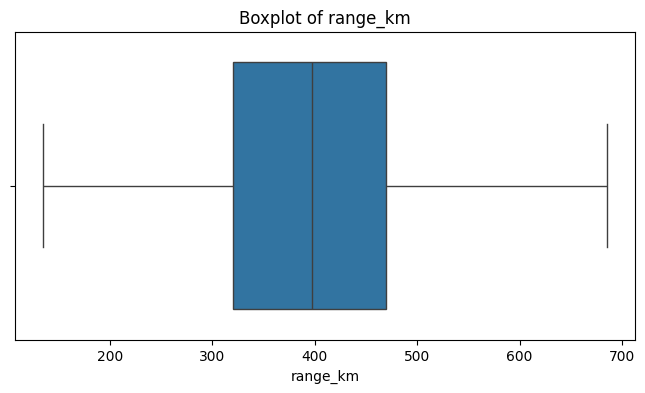

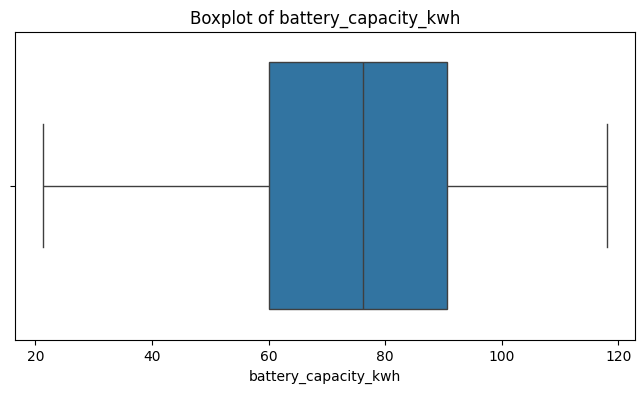

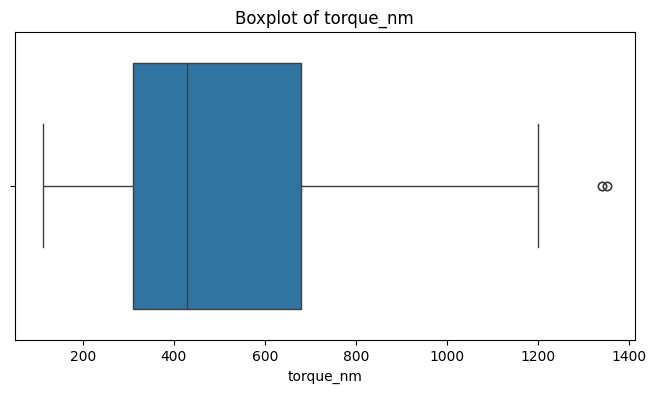

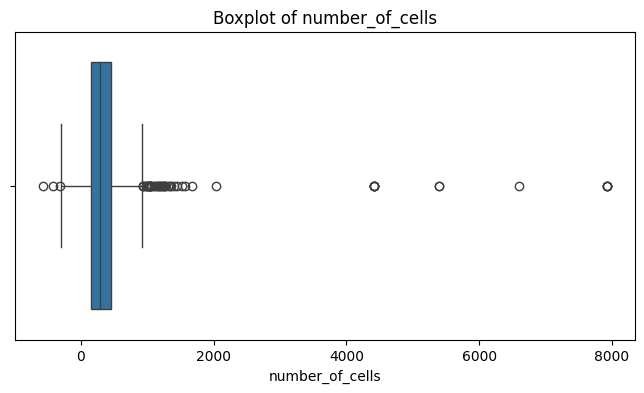

In [ ]:
numeric_cols = ['range_km', 'battery_capacity_kwh', 'torque_nm', 'number_of_cells']
boxplot_univariate(df_cleaned, numeric_cols)

Histograms → View distribution (normal, skewed, etc.)

In [ ]:
def histogram_univariate(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col].dropna(), bins=30, kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

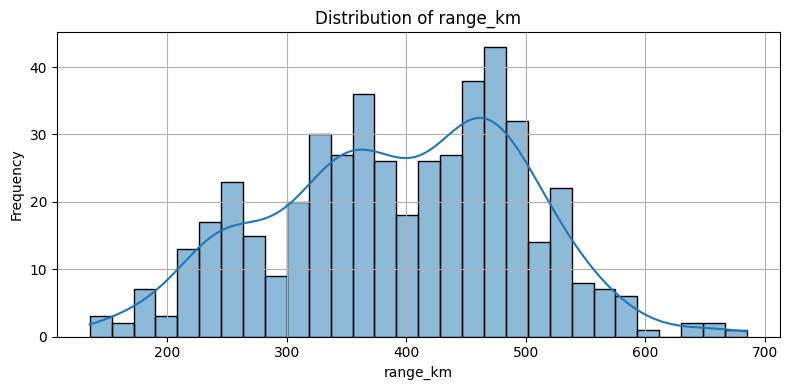

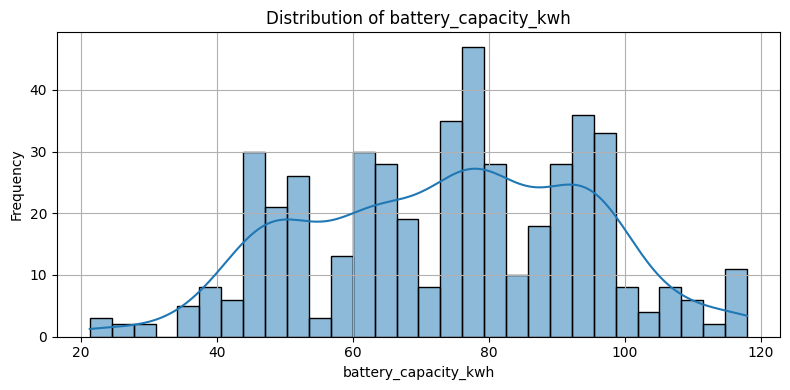

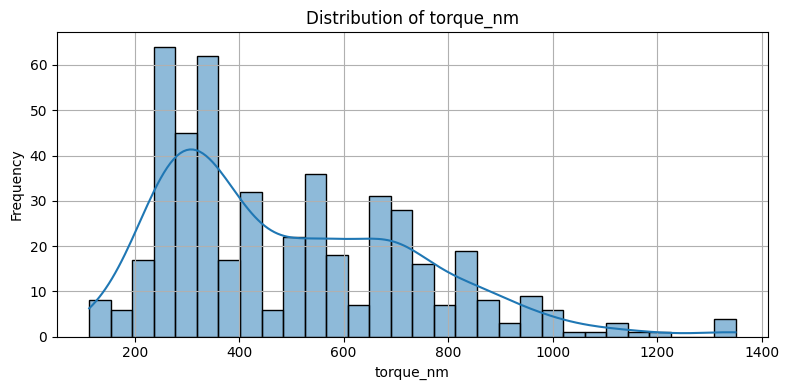

In [ ]:
numeric_cols = ['range_km', 'battery_capacity_kwh', 'torque_nm']
histogram_univariate(df_cleaned, numeric_cols)

# **2. Multivariate Analysis (relationships between variables)**

In [ ]:
def correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    corr_matrix = df.corr(numeric_only=True)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()

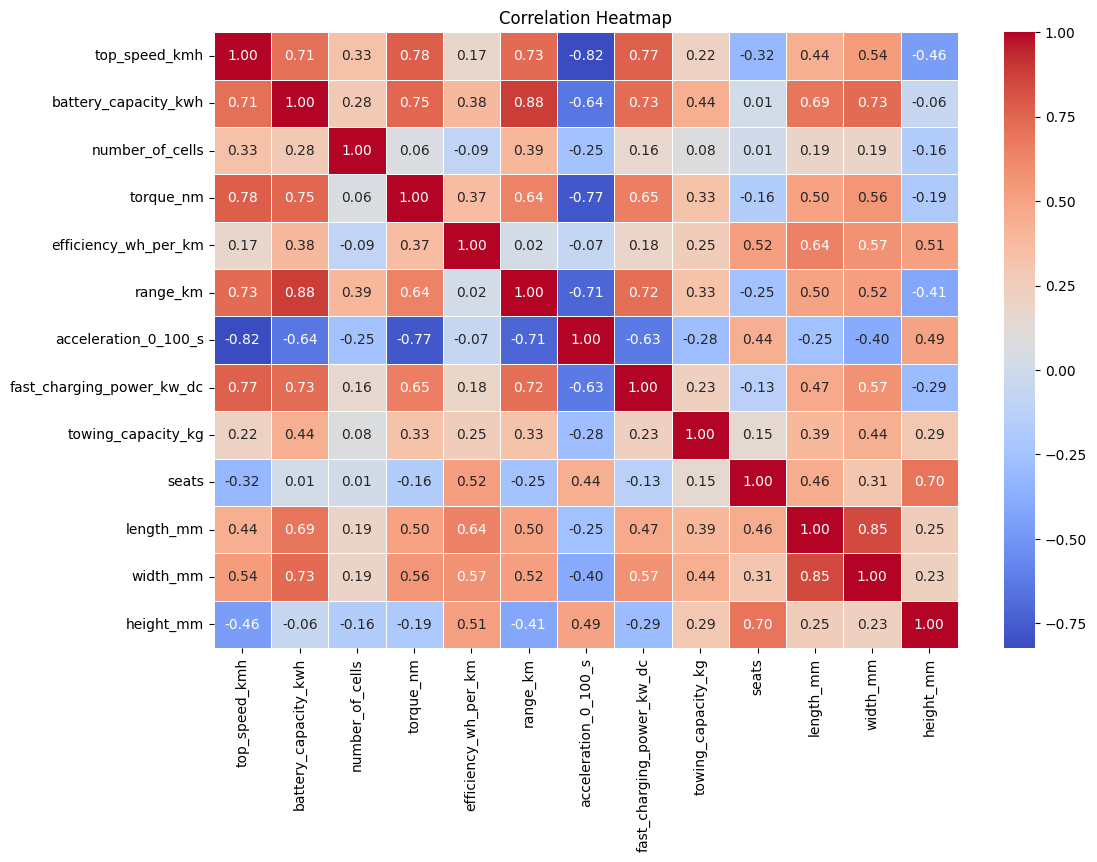

In [ ]:
correlation_heatmap(df_cleaned)

Pairplot → Scatterplots + histograms + class analysis (optional hue)

In [ ]:
def pairplot_analysis(df, columns, hue=None):
    sns.pairplot(df[columns], hue=hue, diag_kind='kde')
    plt.suptitle("Pairplot Analysis", y=1.02)
    plt.show()

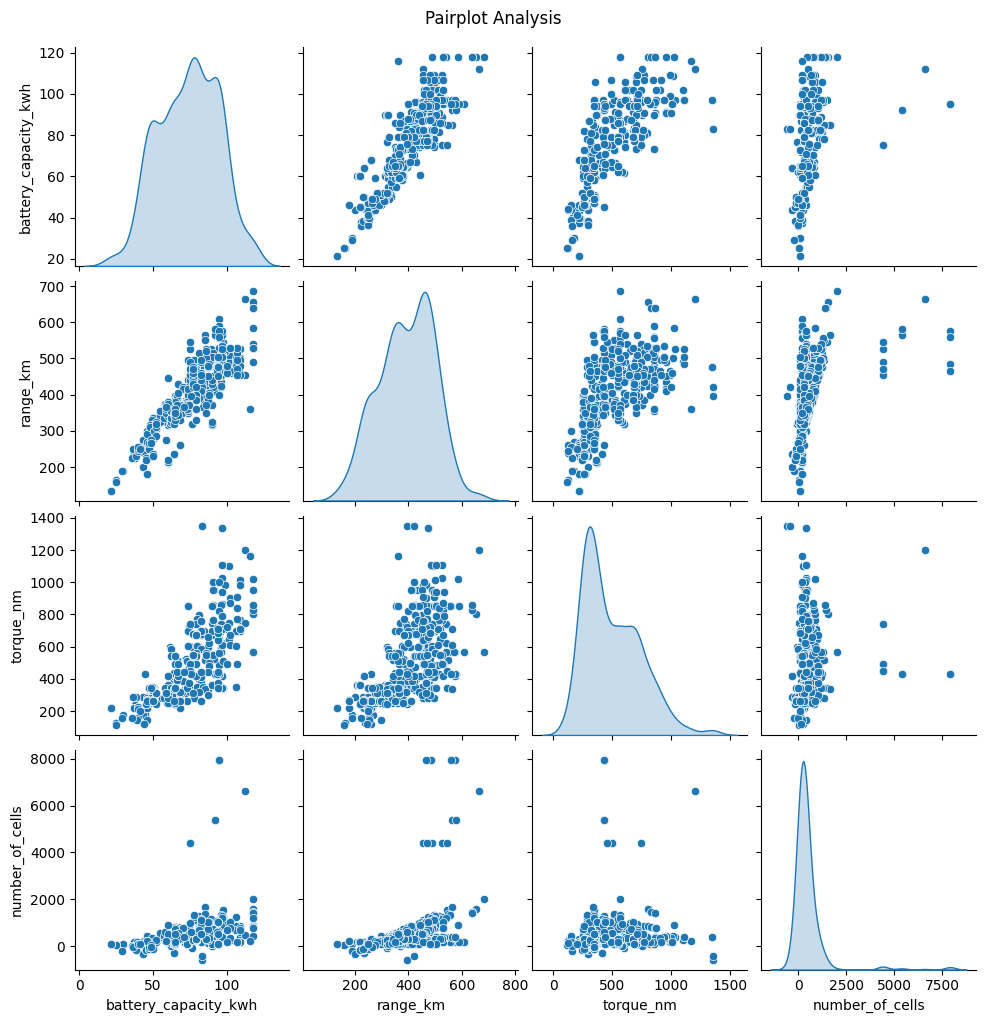

In [ ]:
pairplot_cols = ['battery_capacity_kwh', 'range_km', 'torque_nm', 'number_of_cells']
pairplot_analysis(df_cleaned, pairplot_cols)

Based on the visual analysis, we observe that the range_km and battery_capacity_kwh variables are the strongest predictors of real-world driving range, showing a clear positive correlation (r = 0.88). The range_km distribution is centered between 300–500 km, indicating that most electric vehicles in the dataset can realistically achieve 240–400 km under WLTP-like conditions (assuming 80% efficiency). Torque (torque_nm) is right-skewed with some high outliers but remains moderate for most vehicles, suggesting it won't significantly reduce efficiency unless driven aggressively. In contrast, number_of_cells shows extreme outliers and should be cleaned before being considered reliable. The heatmap and pairplot confirm these relationships and highlight the potential to filter vehicles suitable for tourism in regions like San Pedro de Atacama by applying a threshold, e.g., range_km * 0.8 >= 250. Overall, the data supports building a tool that estimates real autonomy and flags the need for recharging based on trip distance and vehicle specs.

Summarizing and filtering

Of everything analyzed, I want a list of the cars that do meet the criteria.


In [ ]:
df_cleaned['real_range_wltp_km'] = df_cleaned['range_km'] * 0.8

selected_vehicles = df_cleaned[
    (df_cleaned['range_km'] >= 525) &
    (df_cleaned['battery_capacity_kwh'] >= 60) &
    (df_cleaned['torque_nm'] <= 1000) &
    (df_cleaned['fast_charge_port'] != 'Unknown')
]

In [ ]:
selected_vehicles = selected_vehicles[[
    'brand', 'model', 'range_km', 'real_range_wltp_km',
    'battery_capacity_kwh', 'torque_nm', 'fast_charge_port',
    'car_body_type', 'segment'
]].sort_values(by='real_range_wltp_km', ascending=False)

/tmp/ipython-input-23-3924030503.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=brand_counts, x='vehicle_count', y='brand', palette='viridis')


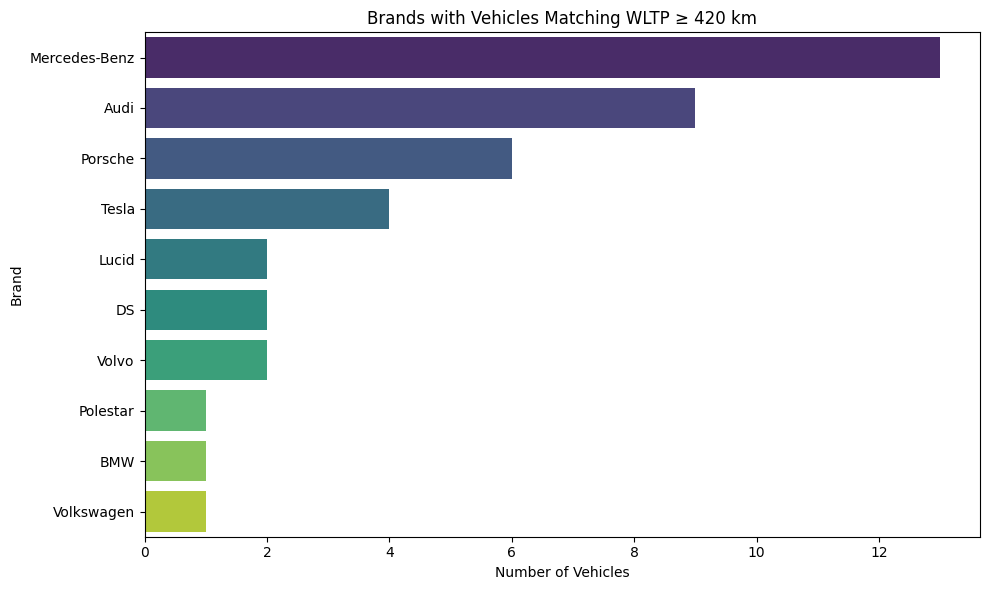

In [ ]:
# Count vehicles by brand in selected list
brand_counts = selected_vehicles['brand'].value_counts().reset_index()
brand_counts.columns = ['brand', 'vehicle_count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=brand_counts, x='vehicle_count', y='brand', palette='viridis')
plt.title('Brands with Vehicles Matching WLTP ≥ 420 km')
plt.xlabel('Number of Vehicles')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

In [ ]:
mercedes_models = selected_vehicles[selected_vehicles['brand'] == 'Mercedes-Benz']

/tmp/ipython-input-25-1922950713.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mercedes_models, x='real_range_wltp_km', y='model', palette='Blues_d')


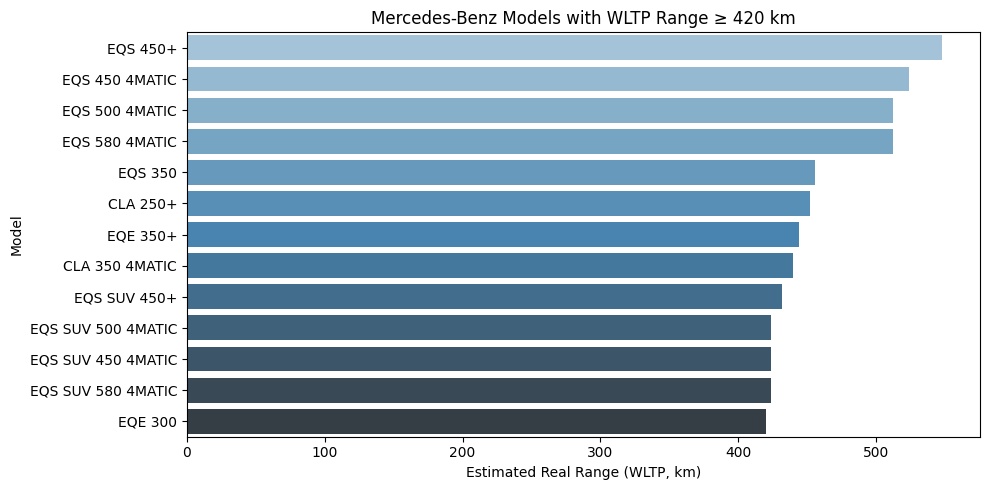

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=mercedes_models, x='real_range_wltp_km', y='model', palette='Blues_d')
plt.title('Mercedes-Benz Models with WLTP Range ≥ 420 km')
plt.xlabel('Estimated Real Range (WLTP, km)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

/tmp/ipython-input-26-2997340555.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_torque, x='torque_nm', y='brand', palette='mako')


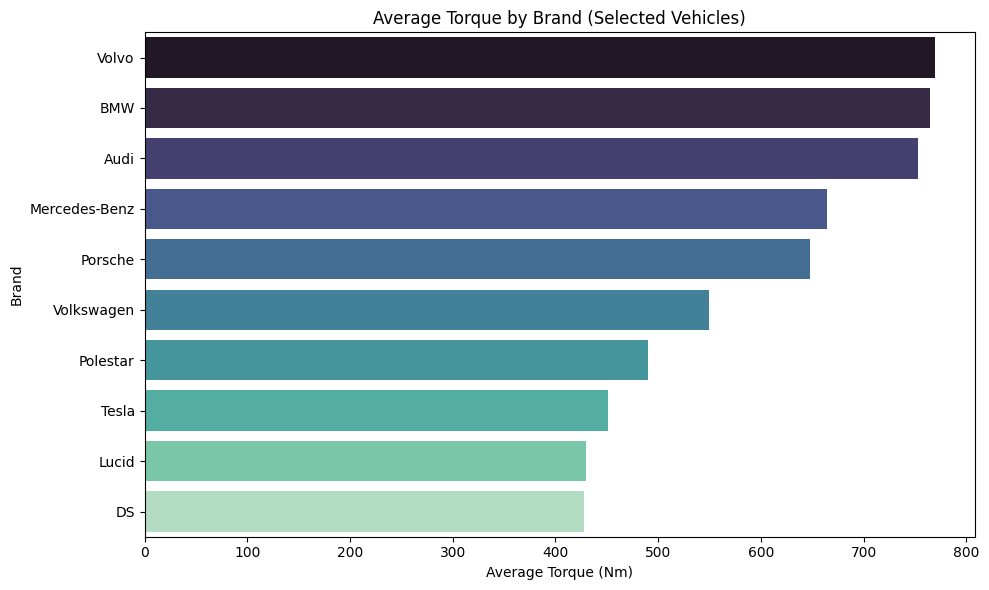

In [ ]:
# Calculate average torque per brand
avg_torque = selected_vehicles.groupby('brand')['torque_nm'].mean().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_torque, x='torque_nm', y='brand', palette='mako')
plt.title('Average Torque by Brand (Selected Vehicles)')
plt.xlabel('Average Torque (Nm)')
plt.ylabel('Brand')
plt.tight_layout()
plt.show()

In [ ]:
volvo_models = selected_vehicles[selected_vehicles['brand'] == 'Volvo']

volvo_models = volvo_models[[
    'model', 'range_km', 'real_range_wltp_km',
    'battery_capacity_kwh', 'torque_nm',
    'fast_charge_port', 'car_body_type', 'segment'
]].sort_values(by='real_range_wltp_km', ascending=False)


/tmp/ipython-input-64-1189862787.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volvo_models, x='real_range_wltp_km', y='model', palette='crest')


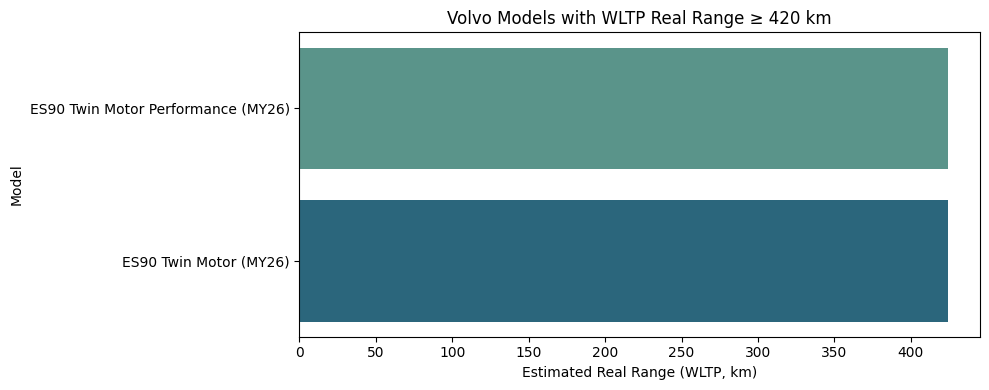

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=volvo_models, x='real_range_wltp_km', y='model', palette='crest')
plt.title('Volvo Models with WLTP Real Range ≥ 420 km')
plt.xlabel('Estimated Real Range (WLTP, km)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [ ]:
volvo_high_torque = selected_vehicles[
    (selected_vehicles['brand'] == 'Volvo') &
    (selected_vehicles['torque_nm'] > 700)
]

/tmp/ipython-input-30-3378350948.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=volvo_high_torque, x='torque_nm', y='model', palette='rocket')


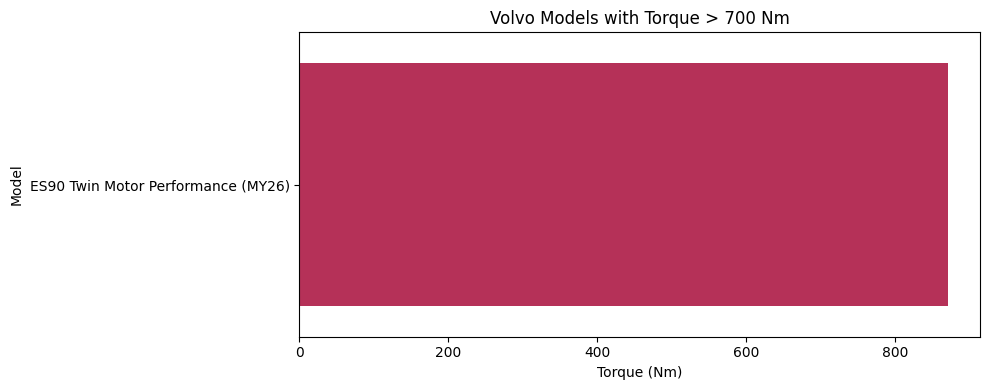

In [ ]:
plt.figure(figsize=(10, 4))
sns.barplot(data=volvo_high_torque, x='torque_nm', y='model', palette='rocket')
plt.title('Volvo Models with Torque > 700 Nm')
plt.xlabel('Torque (Nm)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

outliers with more than 1000 Nm of torque, and get their brand and model

In [ ]:
torque_outliers = df_cleaned[df_cleaned['torque_nm'] > 1000]

In [ ]:
torque_outliers = torque_outliers[[
    'brand', 'model', 'torque_nm', 'range_km',
    'battery_capacity_kwh', 'fast_charge_port'
]].sort_values(by='torque_nm', ascending=False)

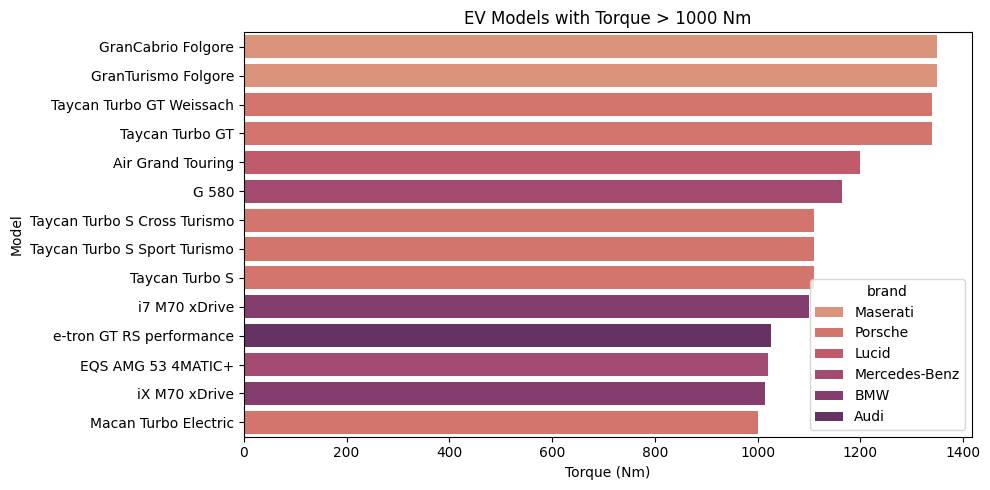

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=torque_outliers, x='torque_nm', y='model', hue='brand', dodge=False, palette='flare')
plt.title('EV Models with Torque > 1000 Nm')
plt.xlabel('Torque (Nm)')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# **I will make the torque prediction**

torque will be my target variable and I will use it as features 'top_speed_kmh','battery_capacity_kwh','acceleration_0_100_s','fast_charging_power_kw_dc',    'range_km'

**XGboost**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Select features based on correlation
features = ['top_speed_kmh', 'battery_capacity_kwh', 'acceleration_0_100_s',
            'fast_charging_power_kw_dc', 'range_km']
X = df_cleaned[features]
y = df_cleaned['torque_nm']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Training and evaluation
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append((name, r2, rmse, mae))

# Show results
results_df = pd.DataFrame(results, columns=['Model', 'R2 Score', 'RMSE', 'MAE'])
results_df.sort_values(by='R2 Score', ascending=False)


,Model,R2 Score,RMSE,MAE
1,Random Forest,0.890811,79.120199,51.225532
2,XGBoost,0.882761,81.984866,49.682537
0,Linear Regression,0.764692,116.149067,88.546697


**KNN**

---



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Feature and target selection
features = ['top_speed_kmh', 'battery_capacity_kwh', 'acceleration_0_100_s',
            'fast_charging_power_kw_dc', 'range_km']
X = df_cleaned[features]
y = df_cleaned['torque_nm']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (required for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=15, weights='distance', metric='euclidean')
}

# Training and evaluation
results = []

for name, model in models.items():
    # Use scaled data if model is KNN
    if name == 'KNN':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append((name, r2, rmse, mae))

# Show results
results_df = pd.DataFrame(results, columns=['Model', 'R2 Score', 'RMSE', 'MAE'])
results_df = results_df.sort_values(by='R2 Score', ascending=False)
results_df


,Model,R2 Score,RMSE,MAE
1,Random Forest,0.890811,79.120199,51.225532
2,XGBoost,0.882761,81.984866,49.682537
3,KNN,0.828664,99.110966,63.498182
0,Linear Regression,0.764692,116.149067,88.546697


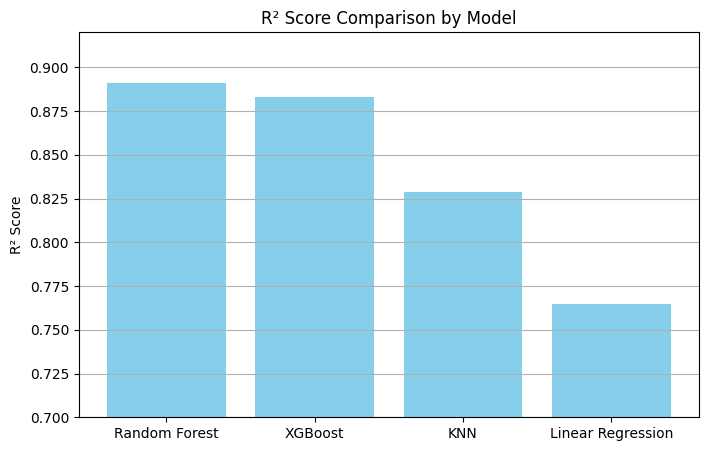

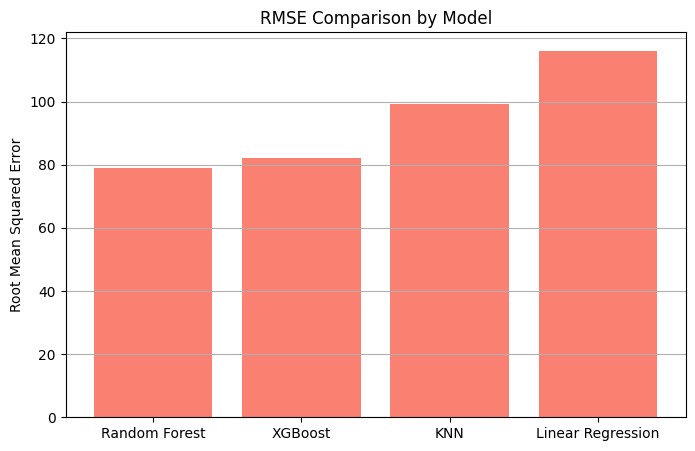

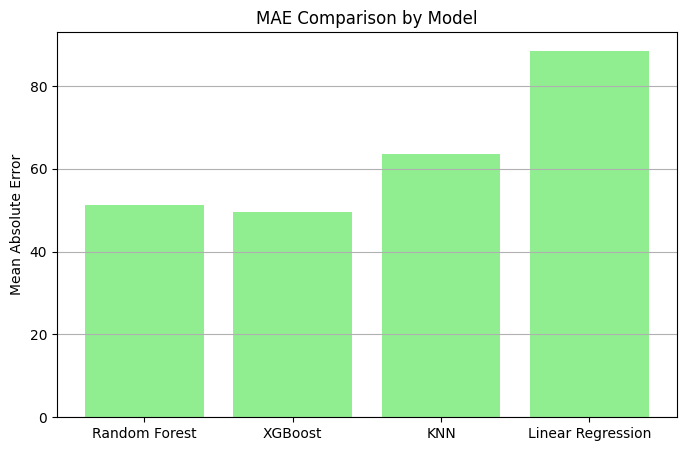

In [ ]:
# R² score comparison chart
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['R2 Score'], color='skyblue')
plt.title('R² Score Comparison by Model')
plt.ylabel('R² Score')
plt.ylim(0.7, 0.92)
plt.grid(axis='y')
plt.show()

# RMSE comparison chart
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['RMSE'], color='salmon')
plt.title('RMSE Comparison by Model')
plt.ylabel('Root Mean Squared Error')
plt.grid(axis='y')
plt.show()

# MAE comparison chart
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['MAE'], color='lightgreen')
plt.title('MAE Comparison by Model')
plt.ylabel('Mean Absolute Error')
plt.grid(axis='y')
plt.show()

Hyperparameter Settings

---



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Tuned Random Forest model (for example)
rf_tuned = RandomForestRegressor(
    n_estimators=300,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Tuned KNN model (for example)
knn_tuned = KNeighborsRegressor(
    n_neighbors=7,
    weights='uniform',
    metric='manhattan'
)

**Training and Evaluation**

---



In [ ]:
# Training and evaluation
results_tuned = []

# RANDOM FOREST TUNED (does not require scaling)
rf_tuned.fit(X_train, y_train)
y_pred_rf = rf_tuned.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
results_tuned.append(('Random Forest Tuned', r2_rf, rmse_rf, mae_rf))

# KNN TUNED (requires scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_tuned.fit(X_train_scaled, y_train)
y_pred_knn = knn_tuned.predict(X_test_scaled)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
mae_knn = mean_absolute_error(y_test, y_pred_knn)
results_tuned.append(('KNN Tuned', r2_knn, rmse_knn, mae_knn))

In [ ]:
# Display results of tuned models
results_tuned_df = pd.DataFrame(results_tuned, columns=['Model', 'R2 Score', 'RMSE', 'MAE'])
results_tuned_df = results_tuned_df.sort_values(by='R2 Score', ascending=False)
results_tuned_df

,Model,R2 Score,RMSE,MAE
0,Random Forest Tuned,0.876579,84.118743,58.368129
1,KNN Tuned,0.789991,109.727610,72.151786


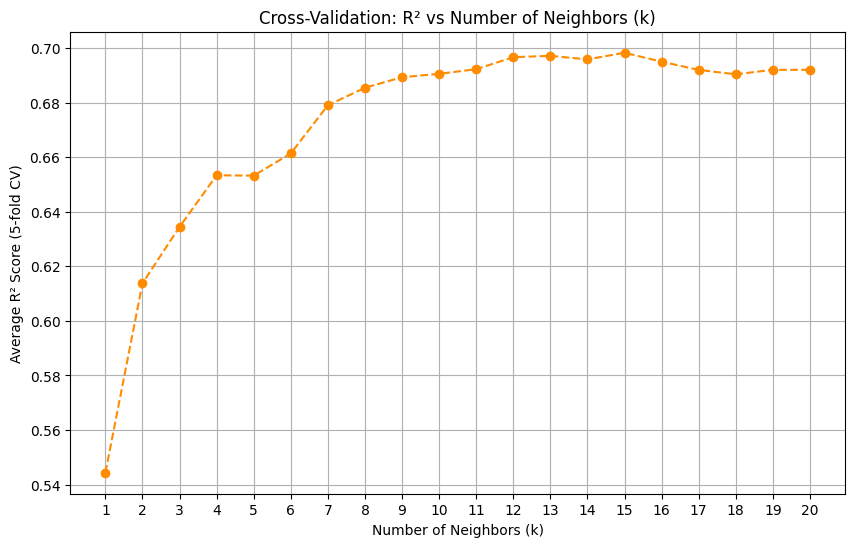

Best k: 15 with average R²: 0.6983


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Scale the data (required for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Test different values of k
k_range = range(1, 21)
mean_r2_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='euclidean')
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='r2')
    mean_r2_scores.append(scores.mean())

# Plot R² vs K
plt.figure(figsize=(10, 6))
plt.plot(k_range, mean_r2_scores, marker='o', linestyle='--', color='darkorange')
plt.title('Cross-Validation: R² vs Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Average R² Score (5-fold CV)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Best k
best_k = k_range[np.argmax(mean_r2_scores)]
best_r2 = max(mean_r2_scores)
print(f"Best k: {best_k} with average R²: {best_r2:.4f}")

**Gridsearch For XGboost**

---



In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the base model
xgb_base = XGBRegressor(random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train the model (this may take a while)
grid_search.fit(X_train, y_train)

# Display best hyperparameters and score
print("Best parameters:", grid_search.best_params_)
print(f"Best R² score: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Best R² score: 0.8855


In [ ]:
# Display the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Optimal model
best_xgb = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_xgb.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

Best hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
R² Score: 0.8811
RMSE: 82.58
MAE: 49.87


**SVR**

---



In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Scaling (SVR requires it)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train SVR model
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred = svr_model.predict(X_test_scaled)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R² Score: 0.1620
RMSE: 219.18
MAE: 159.38


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Pipeline to include scaling + SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5],
    'svr__kernel': ['linear', 'rbf']
}

# GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Train
grid_search.fit(X_train, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
best_svr = grid_search.best_estimator_

# Evaluation
y_pred = best_svr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'svr__C': 100, 'svr__epsilon': 0.5, 'svr__kernel': 'rbf'}
R² Score: 0.8289
RMSE: 99.04
MAE: 63.39


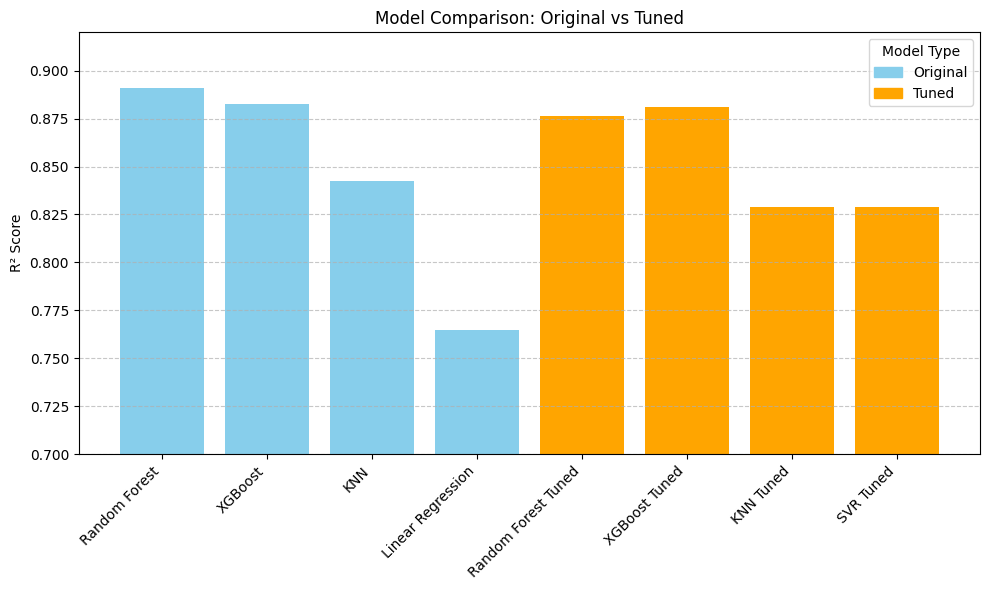

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Original models data
original_models = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'KNN', 'Linear Regression'],
    'R2 Score': [0.8908, 0.8828, 0.8424, 0.7647],
    'Type': ['Original'] * 4
})

# Tuned models data
tuned_models = pd.DataFrame({
    'Model': ['Random Forest Tuned', 'XGBoost Tuned', 'KNN Tuned', 'SVR Tuned'],
    'R2 Score': [0.8766, 0.8811, 0.8287, 0.8289],
    'Type': ['Tuned'] * 4
})

# Combine both
combined_df = pd.concat([original_models, tuned_models], ignore_index=True)

# Color dictionary
colors = {'Original': 'skyblue', 'Tuned': 'orange'}

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(
    combined_df['Model'],
    combined_df['R2 Score'],
    color=[colors[t] for t in combined_df['Type']]
)

plt.title('Model Comparison: Original vs Tuned')
plt.ylabel('R² Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 0.92)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(
    handles=[plt.Rectangle((0, 0), 1, 1, color=c) for c in colors.values()],
    labels=colors.keys(),
    title='Model Type'
)
plt.tight_layout()
plt.show()


---
During this analysis, I compared various regression models with the objective
of predicting the torque (Nm) of electric vehicles, using the following explanatory variables:

* top_speed_kmh (top speed)
* battery_capacity_kwh (battery capacity)
* acceleration_0_100_s (acceleration from 0 to 100 km/h)
* fast_charging_power_kw_dc (fast charging power)
* range_km (driving range).

I initially trained and evaluated baseline models such as Linear Regression, KNN, Random Forest, and XGBoost. Later, I applied hyperparameter tuning using GridSearchCV to improve the performance of KNN, SVR, and XGBoost.

After comparing all results using metrics like R² Score, RMSE, and MAE, I concluded that the best-performing model was Random Forest (without tuning), achieving an R² of 0.8908, an RMSE of 79.12, and an MAE of 51.23. This indicates that the model was able to explain nearly 89% of the variability in torque, with a relatively low margin of error.

In summary, Random Forest emerged as the best option for this problem, outperforming both linear models and more complex tuned techniques. This highlights its ability to capture nonlinear relationships between the selected variables and torque.


---



# **Save and Predicts by User Inputs**

---



 1. Train and Save the Pipeline


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pickle

# Create a pipeline with scaling and Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

# Train the pipeline using training data
rf_pipeline.fit(X_train, y_train)

# Save the trained pipeline to a file
with open('rf_pipeline_model.pkl', 'wb') as file:
    pickle.dump(rf_pipeline, file)

print("🔒 Model saved as 'rf_pipeline_model.pkl'")

🔒 Model saved as 'rf_pipeline_model.pkl'


2. Load the Model and Predict Torque from User Input

In [ ]:
import numpy as np
import pickle

# Suggested value ranges for each feature (can be adjusted)
feature_ranges = {
    'top_speed_kmh': (90, 250),
    'battery_capacity_kwh': (20, 120),
    'acceleration_0_100_s': (2.5, 15),
    'fast_charging_power_kw_dc': (20, 350),
    'range_km': (100, 800)
}

def predict_torque_rf():
    # Load the saved pipeline
    with open('rf_pipeline_model.pkl', 'rb') as file:
        model = pickle.load(file)

    print("🚗 Please enter the following values within the suggested ranges:\n")

    user_input = []
    for feature, (min_val, max_val) in feature_ranges.items():
        while True:
            try:
                value = float(input(f"{feature.replace('_', ' ').title()} ({min_val} - {max_val}): "))
                if min_val <= value <= max_val:
                    user_input.append(value)
                    break
                else:
                    print(f"⚠️  Value must be between {min_val} and {max_val}.")
            except ValueError:
                print("❌ Invalid input. Please enter a number.")

    # Convert input to 2D array for prediction
    X_new = np.array(user_input).reshape(1, -1)
    predicted_torque = model.predict(X_new)

    print(f"\n🔧 Predicted Torque: {predicted_torque[0]:.2f} Nm")

# To use the function, just call:
# predict_torque_rf()

In [ ]:
predict_torque_rf()

🚗 Please enter the following values within the suggested ranges:

Top Speed Kmh (90 - 250): 160
Battery Capacity Kwh (20 - 120): 50
Acceleration 0 100 S (2.5 - 15): 10
Fast Charging Power Kw Dc (20 - 350): 100
Range Km (100 - 800): 200

🔧 Predicted Torque: 306.63 Nm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
